In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import os

from astropy.io import fits
from skimage.filters import threshold_otsu

from scipy.ndimage import shift
from scipy.optimize import curve_fit

from sfilter import sfilter

np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# ----------------------------- Help -------------------------------------

'''
# ---------------------------------------- Переменные -----------------------------------------------------------------
nx - ширина окна для автокорреляции зрачка, должно быть минимум в 2 раза больше, чем ширина зрачка [pix]
I0c - индикатор для зрачка  
f_scale - шаг по частоте, [м^-1]
delta - шаг апертуры или же просто размер 1ого пикселя, [м] 

def frequency_dim - создание пространства частот 
def c_jk - создание коэффициента передачи зрачка
def move_gamma - сдвиг гаммы относительно центра взависимости от скорости ветра
# ---------------------------------------------------------------------------------------------------------------------

Ex:

Для примера пусть Cn2 соответствует качеству изображения, равному 1 угловой секунде (типичное качество изображения) на длине 
волны 500 нм. Для удобства величину Cn2(z)dz рассматриваем как одну величину, обозначим ее C. Тогда:
    beta = 0.98 * lambda/r0 = 1, следовательно: r0 = 0.98*lambda*206265,
Пусть мы наблюдаем в зените, тогда параметр Фрида будет:
    r0 = (0.423*k^2 * C)^(-3/5), где k = 2*pi/lambda.
Далее можно просто выразить и посчитать С
    Cn2_ex = pow((0.98*lambda_)*206265, -5/3) / (0.423*pow(2*np.pi/lambda_, 2))
    
А вообще, нам неважно какое значение Cn2 брать, ответ всегда будет верным
# ---------------------------------------------------------------------------------------------------------------------

Подложки на изображении-результате кросс-корреляции быть не должно (ее видно если брать модуль от мнимой части). Видно, 
что значения мнимой части очень маленькие, поэтому можно выводить сразу действительную часть.
Черные области рядом с пиками - зоны Френеля. По радиусу этих зон можно посчитать дистанцию распространения
'''
print()

In [3]:
# ----------------------------- Монохроматическая гамма -----------------------------------
def gamma_mono(Vx, Vy, Cn2, z, lambda_):
    global frame, D, delta, fx, fy, nx, latency, sec_per_frame
    def frequency_dim(D, frame):
        Dpix = frame.shape[0]
        nx = 2 * Dpix + 1
        const = 9.69*pow(10, -3)*16*pow(np.pi, 2)
        
        f_scale = Dpix/(D*nx) 
        delta = D/Dpix  

        xx, yy = np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx))
        fx = f_scale * xx 
        fy = f_scale * yy
        return fx, fy, delta, nx, f_scale
    
    def c_jk():
        I0c = (frame != 0) * int(1)
        I0c = np.pad(I0c, ((nx - I0c.shape[0])//2, (nx - I0c.shape[1])//2), 'constant', constant_values=(0))
        res = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fft2(I0c)*np.fft.fft2(I0c).conjugate())))
        res /= np.max(res)
        return res

    def move_gamma(Vx, Vy, sec_per_frame, latency):
        t = sec_per_frame * latency
        Lx = Vx*t
        Ly = Vy*t
        Xpix = Lx/delta
        Ypix = Ly/delta
        return Ypix, Xpix
    
    def gamma_mono_int(fx, fy, z, delta, lambda_): 
        def aperture_func(fx, fy, delta): 
            res = np.abs(np.sinc(delta*fx)*np.sinc(delta*fy))**2
            return res
    
        def abs_f(fx, fy):
            res = pow(np.sqrt(fx**2+fy**2), -11./3.)
            return res

        def sin(fx, fy, z, lambda_): 
            res = pow(np.sin(np.pi*z*lambda_*(fx**2+fy**2)), 2) / pow(lambda_, 2)            
            return res  

        res = abs_f(fx, fy) * sin(fx, fy, z, lambda_) * aperture_func(fx, fy, delta)
        res[np.isnan(res)] = 0
    
        return np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fftshift(res))))
    
    fx, fy, delta, nx, f_scale = frequency_dim(D, frame)
    
    const = 9.69*pow(10, -3)*16*pow(np.pi, 2)
    res = Cn2 * const * gamma_mono_int(fx, fy, z, delta, lambda_) * pow(f_scale, 2) * nx * nx
    
    y, x = move_gamma(Vx, Vy, sec_per_frame, latency)
    res = shift(res, (-x, -y), order=5)
    
    res = res * c_jk()
    return res

# ----------------------------- Полихроматическая гамма -----------------------------------
def gamma_poly(Vx, Vy, Cn2, z):
    global frame, D, delta, fx, fy, nx, latency, sec_per_frame  
    def frequency_dim(D, frame):
        Dpix = frame.shape[0]
        nx = 2 * Dpix + 1
        const = 9.69*pow(10, -3)*16*pow(np.pi, 2)
        
        f_scale = Dpix/(D*nx) 
        delta = D/Dpix  

        xx, yy = np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx))
        fx = f_scale * xx 
        fy = f_scale * yy
        return fx, fy, delta, nx, f_scale
    
    def c_jk():
        I0c = (frame != 0) * int(1)
        I0c = np.pad(I0c, ((nx - I0c.shape[0])//2, (nx - I0c.shape[1])//2), 'constant', constant_values=(0))
        res = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fft2(I0c)*np.fft.fft2(I0c).conjugate())))
        res /= np.max(res)
        return res
    
    def move_gamma(Vx, Vy, sec_per_frame, latency):
        t = sec_per_frame * latency
        Lx = Vx*t
        Ly = Vy*t
        Xpix = Lx/delta
        Ypix = Ly/delta
        return Ypix, Xpix
    
    def gamma_poly_int(fx, fy, z, delta): 
        def aperture_func(fx, fy, delta): 
            res = np.abs(np.sinc(delta*fx)*np.sinc(delta*fy))**2
            return res
    
        def abs_f(fx, fy):
            res = pow(np.sqrt(fx**2+fy**2), -11./3.)
            res[np.isnan(res)] = 0
            return res
        
        S = sfilter(D=D, Dpix=frame.shape[0], z=z)   
    
        res = abs_f(fx, fy) * S * aperture_func(fx, fy, delta)
        res[np.isnan(res)] = 0
    
        return np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fftshift(res))))
    
    fx, fy, delta, nx, f_scale = frequency_dim(D, frame)

    const = 9.69*pow(10, -3)*16*pow(np.pi, 2)
    res = Cn2 * const * gamma_poly_int(fx, fy, z, delta) * pow(f_scale, 2) * nx * nx
    
    y, x = move_gamma(Vx, Vy, sec_per_frame, latency)
    res = shift(res, (-x, -y), order=5)
    
    res = res * c_jk()
    return res
 
# ----------------------------- Корреляция -----------------------------------
def correlate(frames, latency): 
    correlation = np.zeros_like(frames)
    def correlate_fft(img1, img2):
        corr = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fft2(img1)*np.fft.fft2(img2).conjugate()))) # np.real; np.abs
        corr /= np.max(corr)
        return corr
    
    for i in range(frames.shape[0] - latency):
        correlation[i] = correlate_fft(frames[i], frames[i + latency])
    
    return np.mean(correlation, axis=0)
    
# ------------- Получение квадратного изображения зрачка и кросс-корреляции -----------------------
def pupil(images, latency): 
    image_average = np.mean(images, axis=0) # средний кадр серии
    image_binary = (image_average > threshold_otsu(image_average)) * int(255) # маска среднего кадра
    def flux_normalize(images): # нормировка потока, <I> = 0
        return (images)/(image_average) - 1

    def pupil_mask(images): # вырез зрачка
        return flux_normalize(images) * image_binary

    def pupil_square_cropp(images): # обрезка зрачка в квадрат
        mask = pupil_mask(images)[np.random.randint(images.shape[0])] != 0
        rows = np.flatnonzero((mask.any(axis=1))) 
        cols = np.flatnonzero((mask.any(axis=0)))
        return pupil_mask(images)[:, rows.min():rows.max()+1, cols.min():cols.max()+1] 
    
    def pupil_size_flatten(image): # подгонка размера изображения под квадратное
        if image.shape[0] >= image.shape[1]:
            image = np.pad(image, ((image.shape[0] - image.shape[1], 0), (0, 0)), 'constant', constant_values=(0))
        if image.shape[0] < image.shape[1]:
            image = np.pad(image, ((image.shape[1] - image.shape[0], 0), (0,0)), 'constant', constant_values=(0))
        return image
    
    res = pupil_square_cropp(images)   
    image = pupil_size_flatten(res[np.random.randint(res.shape[0])])
    
    cross_corr = correlate(res, latency)
    cross_corr = pupil_size_flatten(cross_corr)

    return image, cross_corr  

# ------------------------------- Main -------------------------------
def make_pupil_with_cross_corr(file, file_bias=None, pupil_diameter=None, corr_latency=None):
    global frame, D, latency, sec_per_frame  
    D=pupil_diameter
    latency=corr_latency
    
    with fits.open(file_bias) as f:
        f.info()
        bias = np.mean(f[0].data, axis=0, dtype=np.float32)
    
    with fits.open(file) as f:
        f.info()
        sec_per_frame = 1 / f[0].header['FRATE']
        d = np.float32(f[0].data) - bias 
    
    frame, data_corr = pupil(d, latency) 

    v = (D / frame.shape[0]) / (latency * sec_per_frame)

    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    fig.colorbar(ax.imshow(frame), ax = ax)
    ax.set_title('Pupil image')
    ax.grid(False)

    fig.colorbar(ax2.imshow(data_corr), ax = ax2)
    ax2.set_title(f'Cross-correlation, latency = {latency}')
    x = np.round(v*np.linspace(-data_corr.shape[0]//2, data_corr.shape[0]//2, 5), 2)
    ax2.set_xticks(np.linspace(0, data_corr.shape[1], 5))
    ax2.set_yticks(np.linspace(0, data_corr.shape[0], 5))
    ax2.set_xticklabels(x, fontsize=12)
    ax2.set_yticklabels(x, fontsize=12)
    ax2.set_ylabel('Vy, m/s', fontsize=12)
    ax2.set_xlabel('Vx, m/s', fontsize=12)
    
    print('\nPupil shape:', frame.shape, 'corr shape:', data_corr.shape)
    np.savetxt('C:/astro/data_corr.gz', data_corr)
    np.savetxt('C:/astro/data.gz', frame)
    return data_corr

# -------------------------------- Измерение подкупольной турбулентности --------------------------
def dome_turbulence(window_zoom=None, data_corr=None, wave_type='mono'):
    Cn2_ex = 1*pow(10, -13)
    Vx = 0
    Vy = 0
    if wave_type == 'mono':
        k = np.max(data_corr[data_corr.shape[0]//2-window_zoom:data_corr.shape[0]//2+window_zoom, 
                   data_corr.shape[1]//2-window_zoom:data_corr.shape[1]//2+window_zoom]) \
        / np.max((gamma_mono(Vx, Vy, Cn2_ex, z, lambda_)))

        Cn2 = Cn2_ex * k 
        gamma_new = gamma_mono(Vx, Vy, Cn2, z, lambda_)
        tit = 'Dome turbulence, monochromatic wave'
        
    if wave_type == 'poly':
        k = np.max(data_corr[data_corr.shape[0]//2-window_zoom:data_corr.shape[0]//2+window_zoom, 
                     data_corr.shape[1]//2-window_zoom:data_corr.shape[1]//2+window_zoom]) \
        / np.max((gamma_poly(Vx, Vy, Cn2_ex, z)))

        Cn2 = Cn2_ex * k 
        gamma_new = gamma_poly(Vx, Vy, Cn2, z) 
        tit = 'Dome turbulence, polychromatic wave'
        

    centr = np.unravel_index(np.argmax(gamma_new), gamma_new.shape)

    X = data_corr[:, data_corr.shape[1]//2]
    Y = range(data_corr.shape[0])
    X3 = gamma_new[centr[0]-data_corr.shape[0]//2-1:centr[0]+data_corr.shape[0]//2, gamma_new.shape[1]//2]
    Y3 = range(data_corr.shape[0])

    fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))

    fig.colorbar(ax.imshow(data_corr[data_corr.shape[0]//2-window_zoom:data_corr.shape[0]//2+window_zoom, 
                                 data_corr.shape[1]//2-window_zoom:data_corr.shape[1]//2+window_zoom]), ax = ax)
    ax.grid(False)

    fig.colorbar(ax2.imshow(gamma_new[centr[0]-window_zoom:centr[0]+window_zoom, 
                                      centr[1]-window_zoom:centr[1]+window_zoom]), ax=ax2)
    ax2.grid(False)

    ax3.plot(X, Y, alpha = 1, label = 'original corr', color = 'gray')
    ax3.plot(X3, Y3, alpha = 0.7, ls = '--', label = 'corected gamma', color = 'red')
#     ax3.legend(['Γ', 'γ'], loc=1, prop={'size': 12})
    ax3.legend(['Data', 'Speckle model'], loc=1, prop={'size': 12})
    ax3.grid(color = 'black', linestyle='--', alpha = 0.2)

    # fig.savefig('C:/astro/teor_corr2.png', bbox_inches='tight')

    ax.set_title('Data')
    ax2.set_title('Speckle model')
    ax3.set_title('Comparison of values')
    fig.text(0.15, -0.02, f'Cn2: {Cn2}')
    fig.suptitle(f'{tit}', fontsize=20)
        

In [4]:
# ----------------------------- Inputs -----------------------------------
file = '20210130l_m2km.fits'      # файл с объектом
file_bias = 'bias20210130.fits'   # файл с кадром смещения, bias
corr_latency = 4                  # задержка в кросс-корреляции, [кол-во кадров]
pupil_diameter = 2.5              # диаметр телескопа, [м]
lambda_ = 500 * pow(10, -9)       # длина волны для монохроматического случая, [м]
z = 2000                          # дистанция распространения, [м]

Filename: bias20210130.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (329, 246, 1000)   int16 (rescales to uint16)   
Filename: 20210130l_m2km.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (329, 246, 6000)   int16 (rescales to uint16)   

Pupil shape: (227, 227) corr shape: (227, 227)
time: 141.1914115


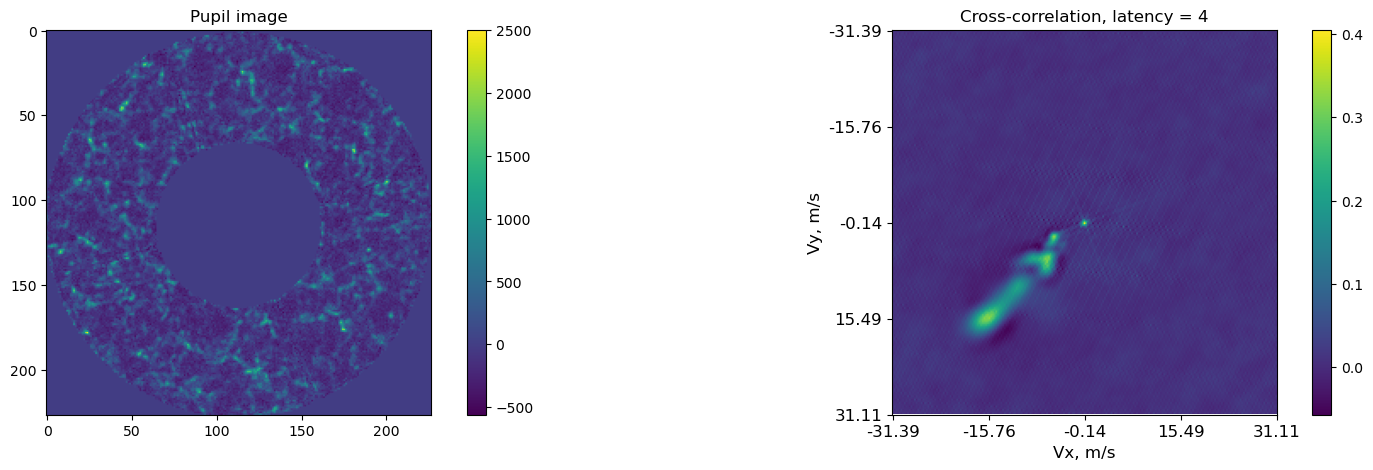

In [5]:
st = time.perf_counter()
data_corr = make_pupil_with_cross_corr(file, file_bias=file_bias, pupil_diameter=pupil_diameter, corr_latency=corr_latency)
print('time:', time.perf_counter()-st)

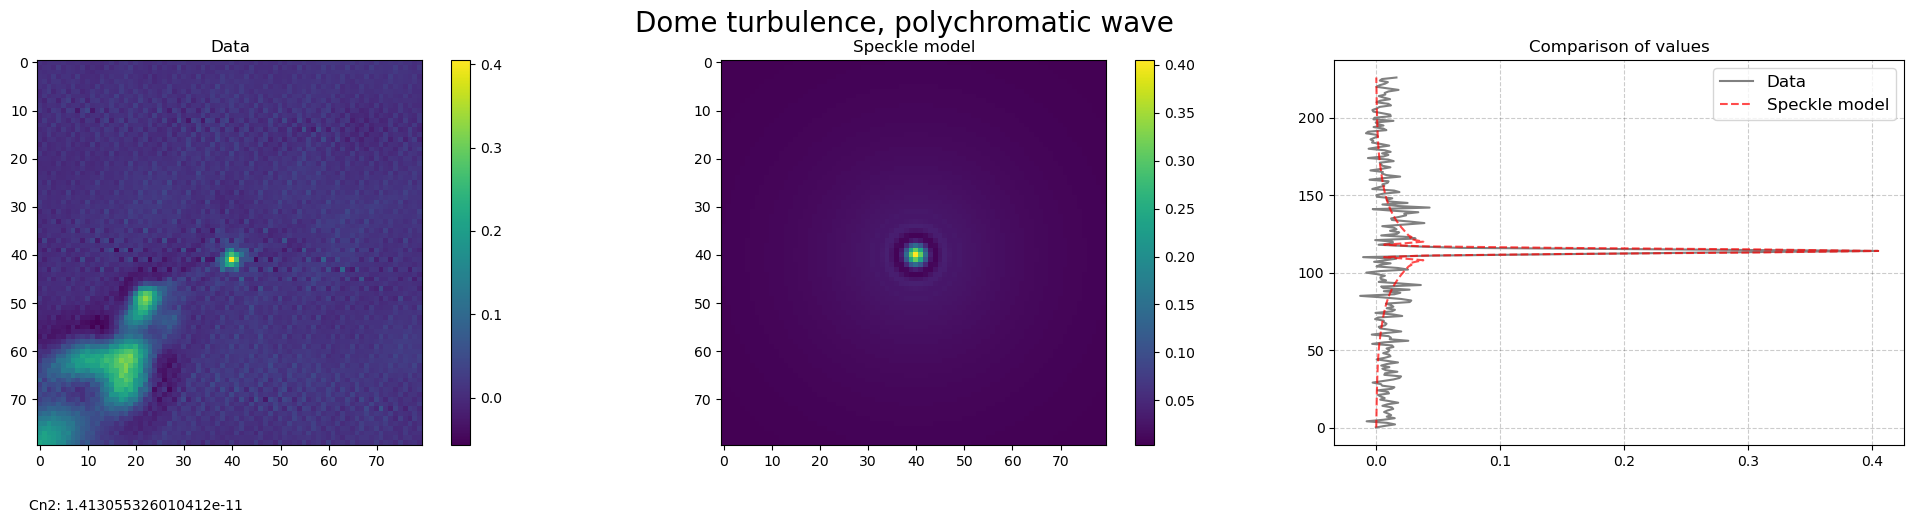

In [6]:
dome_turbulence(window_zoom=40, data_corr=data_corr, wave_type='poly') # Type of wave: 'poly' or 'mono'

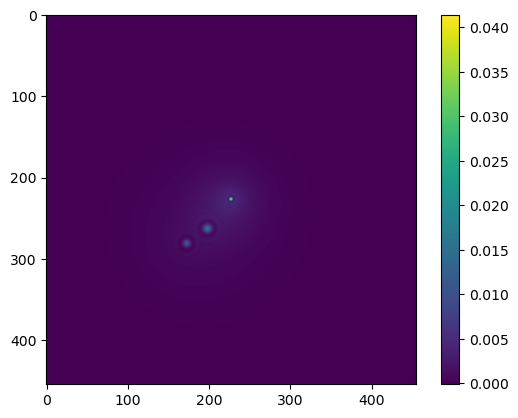

In [7]:
a1 = gamma_poly(0, 0, 1.4*pow(10, -12), 2000)
a2 = gamma_poly(-15, 15, 3*pow(10, -13), 10000)
a3 = gamma_poly(-10, 8, 2*pow(10, -13), 12000)
values = a1 + a2 + a3

plt.figure()
plt.imshow(values)
plt.colorbar()